In [22]:
import cv2
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt




In [23]:
path_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'

dirs = os.listdir(path_dir)[1:]

data = {}

for d in dirs:
    folder_dir = os.path.join(path_dir,d)
    files = os.listdir(folder_dir)

    tifs = []
    for f in files:
        if f.endswith('.tif'):
            tifs.append(os.path.join(folder_dir, f))
    data[d] = tifs


In [24]:
complete_data_fn = []
complete_data_labels = []
for k,key in enumerate(data.keys()):
    print(f"{key}: {len(data[key])}")
    complete_data_fn += data[key]
    complete_data_labels = np.append(complete_data_labels, (k*np.ones(len(data[key]), dtype=int)).astype(np.int))


COMPLETE FEATURE: 76
BORDERTOUCHER: 22
NO FEATURE: 13


In [25]:
label_map = {}
def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'


In [26]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

class Photomask(Dataset):
        def __init__(self,
                    image_files,
                    label):
            self.image_files = image_files
            self.label = label
        def get_image(self, index):
            fn = self.image_files[index]
            return np.array(Image.open(fn))
            
        def __getitem__(self, index=-1):
            if index == -1:
                index = np.random.randint(self.__len__())
            return self.get_image(index), self.label[index]
    
        def __len__(self):
            return len(self.image_files)

In [31]:
label_map = {}
def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'


In [39]:
class transform:
    def normal(img):
        return img
    def fft_mag(img):
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        return 20*np.log(np.abs(fshift))

    def denoise(image, h = 7, block_size = 7, search_window = 21):
        return cv2.fastNlMeansDenoising(image,None,h,block_size,search_window)


In [40]:
ds = Photomask(complete_data_fn, complete_data_labels)


In [46]:
stats = ['max', 'min', 'mean', 'var', 'std']
trans = ['normal', 'fft_mag','denoise']

statistics = {}
for t in trans:
    statistics[t] = {}
    for s in stats:
        statistics[t][s] = []

labels = []

for k in range(ds.__len__()):
    img, label = ds.__getitem__(k)
    labels.append(label)
    for t in trans:
        func_t = getattr(transform, t)
        trans_img = func_t(img)
        for s in stats:
            func_s = getattr(np, s)
            value = func_s(img)
            statistics[t][s].append(value)
        

/Users/lukassanner/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [61]:
idx0 = [i for i, e in enumerate(labels) if e == 0]
idx1 = [i for i, e in enumerate(labels) if e == 1]
idx2 = [i for i, e in enumerate(labels) if e == 2]

Text(0.5, 1.0, 'std')

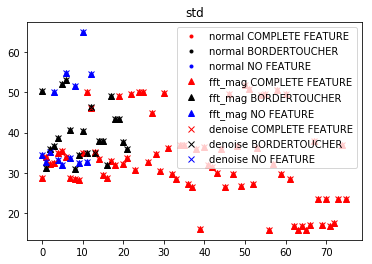

In [75]:
t_sing = ['.','^','x']
c_map = ['r', 'k', 'b']
fig, ax = plt.subplots()
stat_key = 'std'
for i, key in enumerate(statistics.keys()):
    values = np.array(statistics[key][stat_key])
    ax.plot(values[idx0], t_sing[i]+c_map[0], label=key+" "+label_map(0))
    ax.plot(values[idx1], t_sing[i]+c_map[1], label=key+" "+label_map(1))
    ax.plot(values[idx2], t_sing[i]+c_map[2], label=key+" "+label_map(2))
ax.legend()
ax.set_title(stat_key)

Text(0.5, 1.0, 'var')

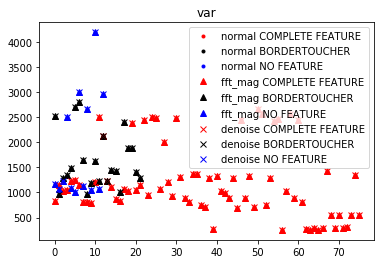

In [76]:
t_sing = ['.','^','x']
c_map = ['r', 'k', 'b']
fig, ax = plt.subplots()

stat_key = 'var'
for i, key in enumerate(statistics.keys()):
    values = np.array(statistics[key][stat_key])
    ax.plot(values[idx0], t_sing[i]+c_map[0], label=key+" "+label_map(0))
    ax.plot(values[idx1], t_sing[i]+c_map[1], label=key+" "+label_map(1))
    ax.plot(values[idx2], t_sing[i]+c_map[2], label=key+" "+label_map(2))
ax.legend()
ax.set_title(stat_key)

Text(0.5, 1.0, 'std')

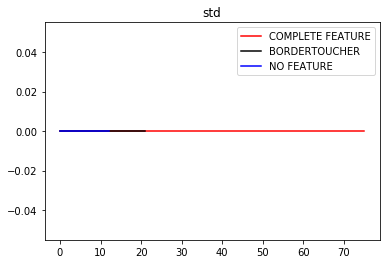

In [78]:
t_sing = ['.','^','x']
c_map = ['r', 'k', 'b']
fig, ax = plt.subplots()

stat_key = 'std'

denoised_values = np.array(statistics['denoise'][stat_key])

normal_values = np.array(statistics['normal'][stat_key])

diff = np.abs(denoised_values - normal_values)

ax.plot(diff[idx0], c_map[0], label=label_map(0))
ax.plot(diff[idx1], c_map[1], label=label_map(1))
ax.plot(diff[idx2], c_map[2], label=label_map(2))

ax.legend()
ax.set_title(stat_key)

In [18]:
statistics = {}

over_all_statistics = {}
over_all_statistics['max'] = []
over_all_statistics['std'] = []
over_all_statistics['var'] = []
over_all_statistics['mean'] = []
over_all_statistics['norm_sum'] = []
for d in dirs:
    maxs= []
    stds = []
    variances = []
    means = []
    norm_sums = []
    stats = {}
    

    for fname in data[d]:
        image = np.array(Image.open(fname)) 
        image = cv2.fastNlMeansDenoising(image,75,75,7,21) / 255
        
        norm_sum = np.sum(image) / (image.shape[0] * image.shape[1])
        maximum = np.max(image)
        std = np.std(image)
        var = np.var(image)
        mean = np.mean(image)
        
        maxs.append(maximum)
        stds.append(std)
        variances.append(var)
        means.append(mean)
        norm_sums.append(norm_sum)
        
        over_all_statistics['mean'].append(mean)
        over_all_statistics['max'].append(maximum)
        over_all_statistics['std'].append(std)
        over_all_statistics['var'].append(var)
        over_all_statistics['norm_sum'].append(norm_sum)

    stats['max'] = maxs
    stats['var'] = variances
    stats['std'] = stds
    stats['mean'] = means
    stats['norm_sum'] = norm_sums
    
    statistics[d] = stats
    

Text(0.5, 1.0, 'mean')

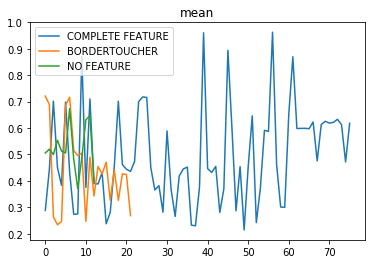

In [12]:
stat_type='mean'
fig, axs= plt.subplots()
for d in dirs:
    axs.plot(statistics[d][stat_type], label=d)

axs.legend()
axs.set_title(stat_type)

Text(0.5, 1.0, 'max')

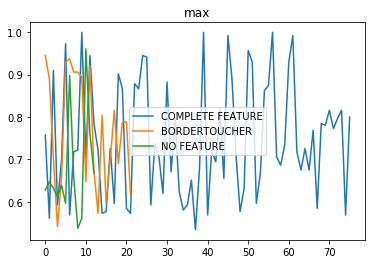

In [13]:
stat_type='max'
fig, axs= plt.subplots()
for d in dirs:
    axs.plot(statistics[d][stat_type], label=d)

axs.legend()
axs.set_title(stat_type)

Text(0.5, 1.0, 'var')

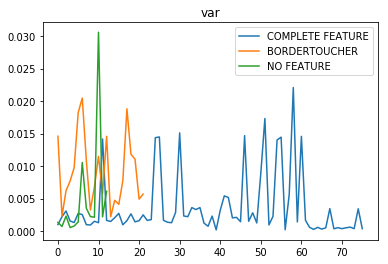

In [14]:
stat_type='var'
fig, axs= plt.subplots()
for d in dirs:
    axs.plot(statistics[d][stat_type], label=d)

axs.legend()
axs.set_title(stat_type)

Text(0.5, 1.0, 'std')

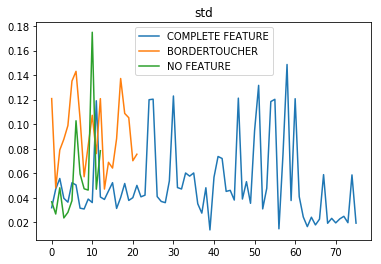

In [15]:
stat_type='std'
fig, axs= plt.subplots()
for d in dirs:
    axs.plot(statistics[d][stat_type], label=d)

axs.legend()
axs.set_title(stat_type)

Text(0.5, 1.0, 'norm_sum')

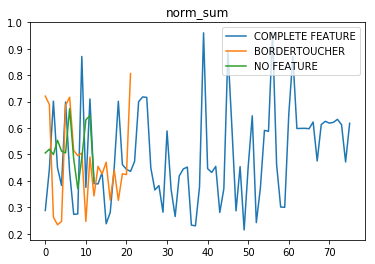

In [19]:
stat_type='norm_sum'
fig, axs= plt.subplots()
for d in dirs:
    axs.plot(statistics[d][stat_type], label=d)

axs.legend()
axs.set_title(stat_type)

for max: min 0.5333333333333333, max 1.0, mean 0.743437555202261
for mean: min 0.21485908302404225, max 0.962173570019724, mean 0.4887088219403385
for std: min 0.013789689697314603, max 0.1748788030355137, mean 0.06058679323883963
for var: min 0.0001901555419482245, max 0.030582595751133992, mean 0.004954569432342282


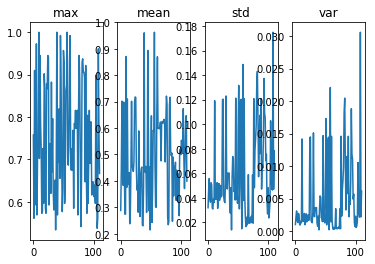

In [16]:
stat_types = ['max', 'mean', 'std', 'var']

for stat_type in stat_types:
    mi= np.min(over_all_statistics[stat_type])
    ma =np.max(over_all_statistics[stat_type])
    mean = np.mean(over_all_statistics[stat_type])
    print(f"for {stat_type}: min {mi}, max {ma}, mean {mean}")
fig, axs = plt.subplots(1,len(stat_types))
for k, stat_type in enumerate(stat_types):
    axs[k].plot(over_all_statistics[stat_type])
    axs[k].set_title(stat_type)

In [ ]:
for key in data.key():
    